In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Constant definitions

In [2]:
# sizes
N = 10
mem = 3

# these are the matrices representing steps and gradient changes
np.random.seed(0)
Y = np.random.randn(N, mem)
S = np.random.randn(N, mem)

# define H0
gamma = 1 # diagonal of H0
H0 = np.eye(N) * gamma

# regularizer
alpha = 1 # scaler of first obj term / regularizer

# Basic program

obj value 16.999608628328136


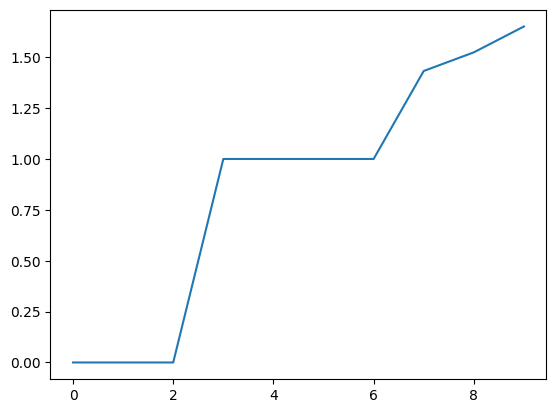

In [3]:
H = cp.Variable((N,N), PSD=True)

distance_from_h0 = cp.sum_squares(H - H0)
soft_secant_condition = cp.sum_squares(H @ Y - S)

objective = alpha * distance_from_h0 + soft_secant_condition

print("obj value", cp.Problem(cp.Minimize(objective)).solve(
    solver='CLARABEL',
    # verbose=True,
))

plt.plot(np.linalg.eigh(H.value)[0])

# Using assumption that H is structured

obj value 16.99960865657171
ACCURACY OF TRANSFORMATION ~ 7.265840368343202e-06


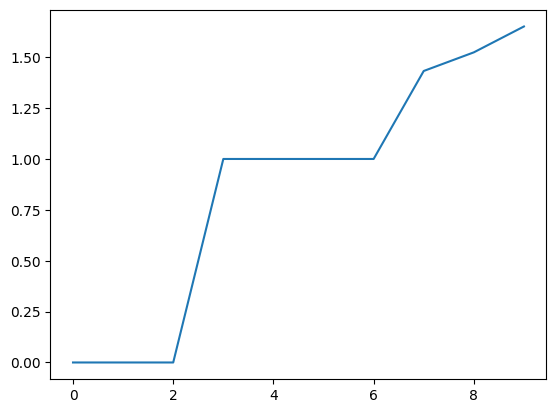

In [4]:
stacked_mat = np.hstack([Y, S])

Sigma = cp.Variable((2*mem, 2*mem), symmetric=True)
structured_H = H0 + stacked_mat @ Sigma @ stacked_mat.T

distance_from_h0 = cp.sum_squares(stacked_mat @ Sigma @ stacked_mat.T)
# soft_secant_condition = cp.sum_squares(structured_H @ Y - S)
soft_secant_condition = cp.sum_squares(gamma * Y + stacked_mat @ Sigma @ (stacked_mat.T @ Y) - S)

objective = alpha * distance_from_h0 + soft_secant_condition

print("obj value", cp.Problem(
    cp.Minimize(objective),
    [structured_H >> 0],
).solve(
    solver='CLARABEL',
    # verbose=True,
))

print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(structured_H.value- H.value)/np.linalg.norm(structured_H.value+ H.value))

plt.plot(np.linalg.eigh(structured_H.value)[0])

# Using SVD

In [5]:
u, s, v = np.linalg.svd(stacked_mat, full_matrices=False)
print(u.shape, s.shape, v.shape)
assert np.allclose(u @ np.diag(s) @ v, stacked_mat)

# these two are the new formulas for Y and S
assert np.allclose(u @ np.diag(s) @ v[:, :mem], Y)
assert np.allclose(u @ np.diag(s) @ v[:, mem:], S)


newSigma = cp.Variable((2*mem, 2*mem), symmetric=True)
newstructured_H = H0 + stacked_mat @ newSigma @ stacked_mat.T

# translating from above
distance_from_h0 = cp.sum_squares(np.diag(s) @ v @ newSigma @ v.T @ np.diag(s))
soft_secant_condition = cp.sum_squares(gamma * np.diag(s) @ v[:, :mem] + np.diag(s) @ v @ newSigma @ v.T @ np.diag(s) @ np.diag(s) @ v[:, :mem] - np.diag(s) @ v[:, mem:])

objective = alpha * distance_from_h0 + soft_secant_condition

print("obj value", cp.Problem(
    cp.Minimize(objective),
    #[ cp.lambda_min(np.diag(s) @ v @ newSigma @ v.T @ np.diag(s)) >= - gamma],# * np.eye(2*mem)],
    # [ np.diag(s) @ v @ newSigma @ v.T @ np.diag(s) >> - gamma * np.eye(2*mem)],
    [ newSigma >> - v.T @ np.diag(1./s) @ (gamma * np.eye(2*mem))  @ np.diag(1./s) @ v],

).solve(
    solver='CLARABEL',
    # verbose=True,
))

print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))


(10, 6) (6,) (6, 6)
obj value 16.999608648203456
ACCURACY OF TRANSFORMATION ~ 4.662613801287173e-06


In [6]:
distance_from_h0.value

array(3.88527649)

In [7]:
assert np.isclose(
    np.trace((np.diag(s) @ v @ newSigma @ v.T @ np.diag(s)).value @ (np.diag(s) @ v @ newSigma @ v.T @ np.diag(s)).value),
    distance_from_h0.value)

assert np.isclose(
    np.trace(np.diag(s) @ v @ newSigma.value @ (v.T @ np.diag(s) @ np.diag(s) @ v) @ newSigma.value @ v.T @ np.diag(s)),
    distance_from_h0.value)

assert np.isclose(
    np.trace(v @ newSigma.value @ (v.T @ np.diag(s**2) @ v) @ newSigma.value @ v.T @ np.diag(s**2)),
    distance_from_h0.value)

In [8]:
np.linalg.eigh(np.diag(s) @ v @ newSigma.value @ v.T @ np.diag(s))[0]

array([-1.        , -1.        , -1.        ,  0.43235167,  0.52393208,
        0.6510328 ])

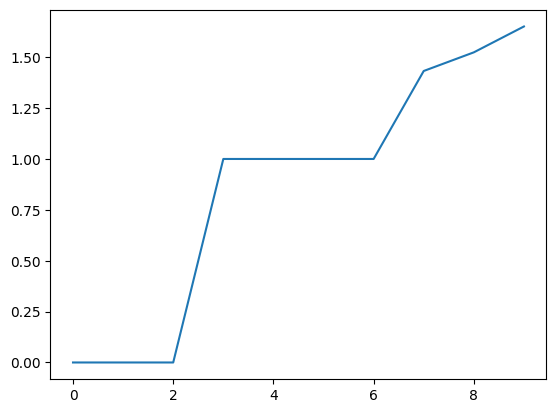

In [9]:
plt.plot(np.linalg.eigh(newstructured_H.value)[0])

# Variable transformation - careful, some CVXPY bug

In [11]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable((2*mem, 2*mem), symmetric=True)

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T

# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition = csp.sum_squares(gamma * np.diag(s) @ v[:, :mem] + Theta @ np.diag(s) @ v[:, :mem] - np.diag(s) @ v[:, mem:])
soft_secant_condition = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem] + np.diag(s) @ (gamma * v[:, :mem] - v[:, mem:]))


objective = alpha * distance_from_h0 + soft_secant_condition

print("obj value", cp.Problem(
    cp.Minimize(objective),
    [cp.lambda_min(Theta) >= - gamma],
).solve(
    # solver='SCS',
    # verbose=True,
))

print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))



obj value 16.9993245796567
ACCURACY OF TRANSFORMATION ~ 1.1922034153676949e-05


# Reshape the objective, remove symmetry/PSD

In [115]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable(
    (2*mem, 2*mem), 
    #symmetric=True
)


# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition1 = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition2 = 2 * cp.trace(Theta @ np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s)  )

objective = alpha * distance_from_h0 + soft_secant_condition1 + soft_secant_condition2

print("obj value", cp.Problem(
    cp.Minimize(objective),
    #[cp.lambda_min(Theta) >= - gamma],
).solve(
    # solver='SCS',
    # verbose=True,
))

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))



obj value -81.74601186048835
ACCURACY OF TRANSFORMATION ~ 0.21814665111217113


# YES

In [119]:
A = np.eye(2*mem) + np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s)
B = np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s)
assert np.allclose(-np.linalg.inv(A) @ B, Theta.value.T)
assert np.allclose(Theta.value @ A, -B.T)

# Add symmetry

In [210]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable(
    (2*mem, 2*mem), 
    symmetric=True
)

# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition1 = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition2 = 2 * cp.trace(Theta @ np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s)  )

objective = alpha * distance_from_h0 + soft_secant_condition1 + soft_secant_condition2

print("obj value", cp.Problem(
    cp.Minimize(objective),
    #[cp.lambda_min(Theta) >= - gamma],
).solve(
    # solver='SCS',
    # verbose=True,
))

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))

obj value -77.31676848823068
ACCURACY OF TRANSFORMATION ~ 0.15879154318533037


#### Error is anti symmetric!

In [211]:
err = Theta.value @ A + B.T
assert np.allclose(err, -err.T)

#### Obtained sort of close formula

In [212]:
# Theta @ A + B.T - err = 0
# err = Theta @ A + B.T
# err = -err.T

# Theta + B.T @ Ainv - err @ Ainv = 0
# Theta + Ainv @ B - Ainv @ err.T = 0
# Theta + Ainv @ B + Ainv @ (Theta @ A + B.T) = 0
# Theta + Ainv @ (B + B.T) + Ainv @ Theta @ A = 0
# A @ Theta + (B + B.T) + Theta @ A = 0

# check it
assert np.allclose(A @ Theta.value +  (B + B.T) + Theta.value @ A, 0.)




# Great idea, this is solvable with only one extra eigendec!

In [213]:
assert np.allclose(A @ Theta.value +  (B + B.T) + Theta.value @ A, 0.)
# A = np.eye(2*mem) + np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s)
C = np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s)

assert np.allclose(2*Theta.value  + C @ Theta.value +  (B + B.T) + Theta.value @ C, 0.)


In [214]:
new_s, V = np.linalg.eigh(C)
assert np.allclose(V @ np.diag(new_s) @ V.T, C)
assert np.allclose(2*Theta.value  + V @ np.diag(new_s) @ V.T @ Theta.value +  (B + B.T) + Theta.value @ V @ np.diag(new_s) @ V.T, 0.)
assert np.allclose(2* V.T @ Theta.value  + np.diag(new_s) @ V.T @ Theta.value +  V.T @ (B + B.T) + V.T @ Theta.value @ V @ np.diag(new_s) @ V.T, 0.)
assert np.allclose(2* V.T @ Theta.value @ V  + np.diag(new_s) @ V.T @ Theta.value @ V +  V.T @ (B + B.T) @ V + V.T @ Theta.value @ V @ np.diag(new_s), 0.)

Lambda = V.T @ Theta.value @ V
assert np.allclose(2* Lambda + np.diag(new_s) @ Lambda+  V.T @ (B + B.T) @ V + Lambda @ np.diag(new_s), 0.)


In [215]:
# plt.imshow((np.ones_like(Lambda) * new_s).T + np.ones_like(Lambda) * new_s + 2 * np.ones_like(Lambda))
# plt.colorbar()

In [216]:
SCALING_MATRIX = (np.ones_like(Lambda) * new_s).T + np.ones_like(Lambda) * new_s + 2 * np.ones_like(Lambda)
assert np.allclose((-V.T @ (B + B.T) @ V) / SCALING_MATRIX, Lambda)

In [217]:
Lambda

array([[-2.53481956e-16, -1.32470915e-16,  4.59402722e-16,
        -3.43364561e-01,  5.25096048e-01, -9.69040479e-02],
       [-1.10172118e-16, -2.12940111e-16, -2.33885609e-16,
         4.54201046e-01,  9.70180705e-02, -3.32908548e-01],
       [ 4.58775620e-16, -2.58079692e-16, -2.11276607e-16,
         4.03606345e-01,  1.93038845e-01,  4.54831945e-01],
       [-3.43364561e-01,  4.54201046e-01,  4.03606345e-01,
        -1.20145407e+00,  1.13176243e-01,  1.01600109e-01],
       [ 5.25096048e-01,  9.70180705e-02,  1.93038845e-01,
         1.13176243e-01, -1.06008923e+00,  4.65673688e-02],
       [-9.69040479e-02, -3.32908548e-01,  4.54831945e-01,
         1.01600109e-01,  4.65673688e-02, -1.22801090e+00]])

#### Can we improve it? No... these transformations are not invertible

In [218]:
# # A = np.eye(2*mem) + np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s)
# # B = np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T @ np.diag(s)

# assert np.allclose(
#     2 * Theta.value +
#     np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta.value +  
#     np.diag(s) @ (
#         v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T
#         + (gamma * v[:, :mem] - v[:, mem:]) @ v[:, :mem].T
#     ) @ np.diag(s) 
#     + Theta.value @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s),
#     0.)

# assert np.allclose(
#     2 * np.diag(1./s) @ Theta.value @ np.diag(1./s) +
#     v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta.value @ np.diag(1./s)+  
#     (
#         v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T
#         + (gamma * v[:, :mem] - v[:, mem:]) @ v[:, :mem].T
#     )
#     + np.diag(1./s) @ Theta.value @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T,
#     0.)

# assert np.allclose(
#     2 * v[:, :mem].T @ np.diag(1./s) @ Theta.value @ np.diag(1./s) +
#     v[:, :mem].T @ np.diag(s) @ Theta.value @ np.diag(1./s)+  
#     (
#          (gamma * v[:, :mem] - v[:, mem:]).T
#         + (gamma * np.eye(mem)) @ v[:, :mem].T
#     )
#     + v[:, :mem].T @ np.diag(1./s) @ Theta.value @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T,
#     0.)

# # this is nice but it's a smaller set of equations, not enough
# assert np.allclose(
#     2 * v[:, :mem].T @ np.diag(1./s) @ Theta.value @ np.diag(1./s) @ v[:, mem:] +
#     v[:, :mem].T @ np.diag(s) @ Theta.value @ np.diag(1./s) @ v[:, mem:]+  
#     (- (gamma * np.eye(3) )),
#     0.)


In [219]:
# v[:, mem:]  @ v[:, mem:].T

### PSD part 

In [220]:
ONLY_SYMMETRIC_THETA = Theta.value
PROJECTED_THETA = eivec @ np.diag(np.maximum(eival, -gamma)) @ eivec.T

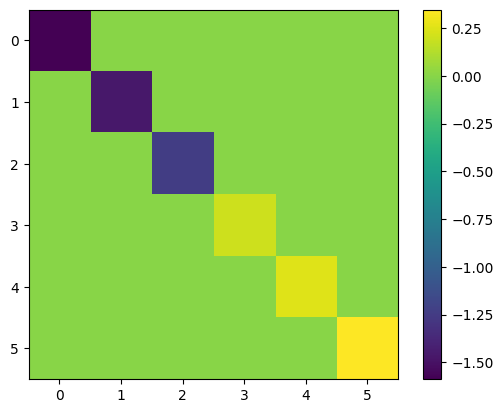

In [221]:
eival, eivec = np.linalg.eigh(Theta.value)
plt.imshow(eivec.T @ Theta.value @ eivec)
plt.colorbar()

# Add PSD

In [253]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable(
    (2*mem, 2*mem), 
    symmetric=True
)

# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition1 = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition2 = 2 * cp.trace(np.diag(s) @ Theta @ np.diag(s) @ v[:, :mem] @ (gamma * v[:, :mem] - v[:, mem:]).T )

objective = alpha * distance_from_h0 + soft_secant_condition1 + soft_secant_condition2

print("obj value", cp.Problem(
    cp.Minimize(objective),
    [cp.lambda_min(Theta) >= - gamma],
).solve(
    solver='SCS',
    eps=1e-14
    # verbose=True,
))

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))

obj value -70.86768011432552
ACCURACY OF TRANSFORMATION ~ 3.403974469073214e-06


# Check with KKT system of only symmetric

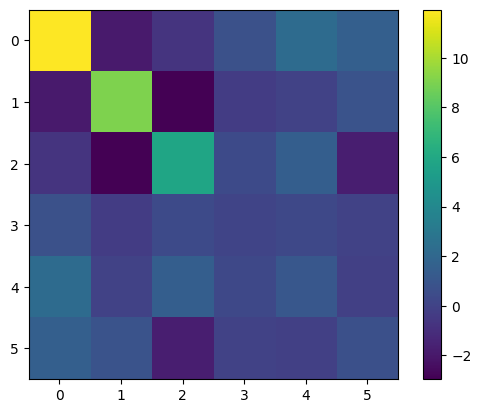

In [260]:
# this was zero with symm
Dual = 2*Theta.value  + C @ Theta.value +  (B + B.T) + Theta.value @ C
plt.imshow(Dual)
plt.colorbar()


# Great, that's looks like the KKT change we need 

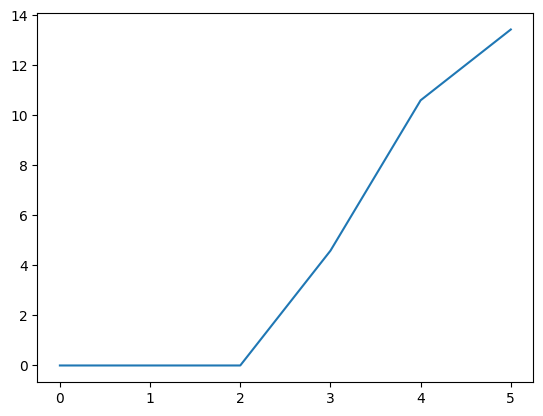

In [261]:
plt.plot(np.linalg.eigh(Dual)[0])
# plt.plot(np.linalg.eigh(ONLY_SYMMETRIC_THETA)[0])

# YES! the condition that I though

In [262]:
assert np.allclose(Dual @ (Theta.value + np.eye(2*mem)), 0.)

# So the KKT conditions are like this

In [ ]:
# 2*Theta.value  + C @ Theta.value +  (B + B.T) + Theta.value @ C = Dual
# Dual + Dual @ Theta.value = 0
# Dual >> 0

In [272]:
new_s, V = np.linalg.eigh(C)
Lambda = V.T @ Theta.value @ V
assert np.allclose(2* Lambda + np.diag(new_s) @ Lambda + Lambda @ np.diag(new_s), V.T @ (Dual) @ V - V.T @ (B + B.T) @ V)
assert np.allclose(Dual + Dual @ Theta.value, 0)
rotated_dual = V.T @ (Dual) @ V
rotated_const = V.T @ (B + B.T) @ V

assert np.allclose(2* Lambda + np.diag(new_s) @ Lambda + Lambda @ np.diag(new_s), rotated_dual - rotated_const)
assert np.allclose(rotated_dual +rotated_dual @ Lambda, 0)

SCALING_MATRIX = (np.ones_like(Lambda) * new_s).T + np.ones_like(Lambda) * new_s + 2 * np.ones_like(Lambda)

# Here we are
assert np.allclose(SCALING_MATRIX * Lambda, rotated_dual - rotated_const)
assert np.allclose(rotated_dual +rotated_dual @ Lambda, 0)
assert np.isclose(np.min(np.linalg.eigh(rotated_dual)[0]), 0.)


## Solve these!

In [341]:
# Here we are
# assert np.allclose(np.sqrt(SCALING_MATRIX) * Lambda * np.sqrt(SCALING_MATRIX) - rotated_dual, - rotated_const)
assert np.allclose(2* Lambda + np.diag(new_s) @ Lambda + Lambda @ np.diag(new_s), rotated_dual - rotated_const)
assert np.allclose(2 * rotated_dual + rotated_dual @ Lambda + Lambda @ rotated_dual, 0)
assert np.min(np.linalg.eigh(rotated_dual)[0]) >= -1e-6
assert np.min(np.linalg.eigh(Lambda)[0]) >= -1 -1e-6


# If I use this I only need first equation above

In [364]:
def spd_proj(sym_mat):
    eival, eivec = np.linalg.eigh(sym_mat)
    return eivec @ np.diag(np.maximum(eival, 0.)) @ eivec.T

pridual = Lambda + np.eye(2*mem) - rotated_dual

assert(np.allclose(spd_proj(pridual) -  np.eye(2*mem),  Lambda))
assert(np.allclose(spd_proj(pridual) - pridual,  rotated_dual))

### Let's try to rewrite it?

In [365]:
assert np.allclose(
    2 * (spd_proj(pridual) -  np.eye(2*mem)) 
    + np.diag(new_s) @ (spd_proj(pridual) -  np.eye(2*mem)) 
    + (spd_proj(pridual) -  np.eye(2*mem)) @ np.diag(new_s),
    spd_proj(pridual) - pridual - rotated_const)


In [370]:
assert np.allclose(
    + pridual
    + spd_proj(pridual)
    + np.diag(new_s) @ spd_proj(pridual) 
    + spd_proj(pridual) @ np.diag(new_s),
    
    2 * np.eye(2*mem)  - rotated_const + 2 * np.diag(new_s) )


## This seems the shortest I can make it...

In [377]:
NEW_SCALING_MATRIX = (
    np.ones_like(Lambda) * new_s).T + np.ones_like(Lambda) * new_s + np.ones_like(Lambda)

assert np.allclose(
    + pridual
    + spd_proj(pridual) * NEW_SCALING_MATRIX,
    2 * np.eye(2*mem)  - rotated_const + 2 * np.diag(new_s) )



# END

In [378]:
raise Exception

Exception: 

In [352]:
np.linalg.eigh(rotated_dual)[0], np.linalg.eigh(Lambda + np.eye(2*mem))[0]

(array([-8.95648264e-15,  1.85890060e-15,  8.94874448e-15,  4.58474878e+00,
         1.05929614e+01,  1.34219434e+01]),
 array([2.86504861e-15, 3.48910132e-15, 3.98487684e-15, 1.43234774e+00,
        1.52392510e+00, 1.65104156e+00]))

#### Common diagonalizer of Lambda and rotated dual

In [319]:
testV = np.linalg.eigh(rotated_dual + Lambda)[1]

dua_diag = np.diag(testV.T @ rotated_dual @ testV )
lam_diag = np.diag(testV.T @ Lambda @ testV )

rotated_rotated_s = testV.T @ np.diag(new_s) @ testV
rotated_rotated_const = testV.T @ rotated_const @ testV

# WE GET TO THIS FORM
assert np.allclose(2* np.diag(lam_diag) + rotated_rotated_s @ np.diag(lam_diag) + np.diag(lam_diag) @ rotated_rotated_s, np.diag(dua_diag) - rotated_rotated_const)
assert np.allclose(dua_diag * (lam_diag + 1), 0.)
assert np.isclose(np.min(dua_diag), 0.)



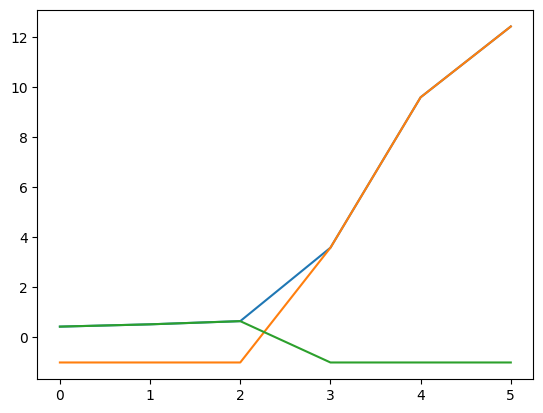

In [334]:
plt.plot(np.diag( testV.T @ (rotated_dual + Lambda) @ testV ))
plt.plot(np.diag(testV.T @ (rotated_dual) @ testV) -1.)
plt.plot(np.diag(testV.T @ (Lambda) @ testV))


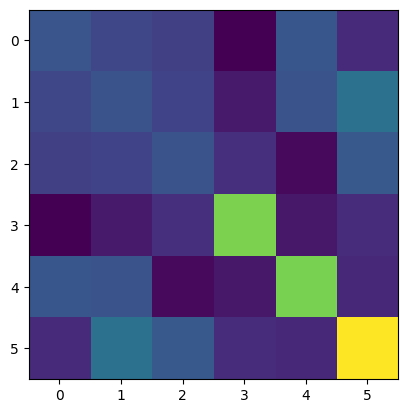

In [321]:
plt.imshow(rotated_rotated_s)

In [299]:
# testV = np.linalg.eigh(rotated_dual + Lambda)[1]
# #plt.imshow(
# testV @ (rotated_const/ SCALING_MATRIX) @ testV.T
# #)#, testV @ rotated_const @ testV.T

array([[ 0.25905885,  0.29343579,  0.05801293, -0.06437953, -0.5710532 ,
         0.46486067],
       [ 0.29343579,  0.09795471,  0.05062791, -0.21987913, -0.61493611,
        -0.06761057],
       [ 0.05801293,  0.05062791, -0.15810656,  0.29207851, -0.15820068,
        -0.2180224 ],
       [-0.06437953, -0.21987913,  0.29207851,  1.15439953, -0.03774851,
         0.04318343],
       [-0.5710532 , -0.61493611, -0.15820068, -0.03774851,  0.87480762,
         0.27111494],
       [ 0.46486067, -0.06761057, -0.2180224 ,  0.04318343,  0.27111494,
         1.26144005]])

In [ ]:
testV = np.linalg.eigh(ro / SCALING_MATRIX)[1]

In [285]:
# testV = np.linalg.eigh(rotated_const / SCALING_MATRIX)[1]
# testV.T @ rotated_dual @ testV, testV @ rotated_dual @ testV.T

In [286]:
# testV = np.linalg.eigh(rotated_const)[1]
# testV.T @ rotated_dual @ testV, testV @ rotated_dual @ testV.T

# End

In [340]:
raise Exception

Exception: 

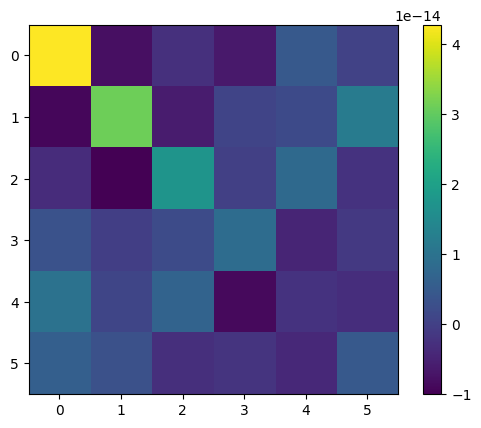

In [257]:
plt.imshow(old_kkt @ (Theta.value + np.eye(2*mem)))
plt.colorbar()

In [250]:
np.diag(myV.T @ Theta.value @ myV)

array([ 0.50668738,  0.63636391,  0.46421619, -1.        , -1.        ,
       -1.        ])

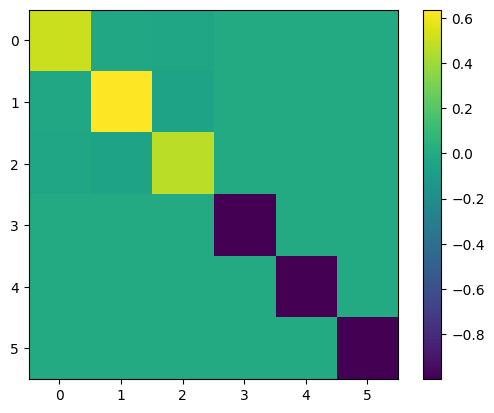

In [248]:
plt.imshow(myV.T @ Theta.value @ myV)
plt.colorbar()

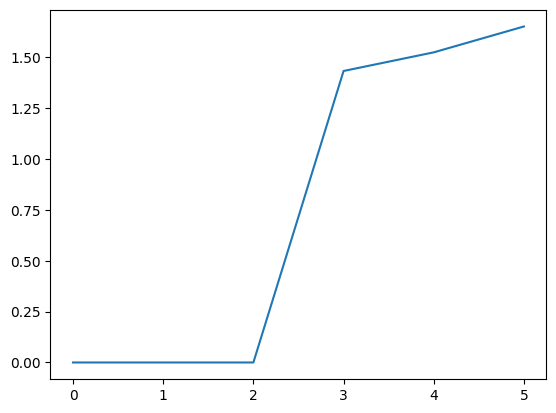

In [241]:
plt.plot(np.linalg.eigh(Theta.value + np.eye(2 * mem))[0])


In [233]:
old_kkt @ Theta.value

array([[-1.19385388e+01,  1.89102850e+00,  7.12258809e-01,
        -7.11338075e-01, -2.23898174e+00, -1.55761221e+00],
       [ 1.89104181e+00, -9.05948555e+00,  2.95852582e+00,
         2.98289631e-01, -3.13406693e-03, -8.35565215e-01],
       [ 7.12367478e-01,  2.95849738e+00, -5.78103802e+00,
        -3.71247604e-01, -1.49983038e+00,  1.68108711e+00],
       [-7.11467724e-01,  2.98149933e-01, -3.71158295e-01,
        -7.23891687e-02, -2.57376901e-01,  2.04685799e-02],
       [-2.23901888e+00, -3.01333479e-03, -1.49971383e+00,
        -2.57349884e-01, -1.09808199e+00,  1.19682282e-01],
       [-1.55748760e+00, -8.35648853e-01,  1.68116091e+00,
         2.05277318e-02,  1.19766149e-01, -6.50334175e-01]])

### Sadly not trivial projection

In [223]:
# #plt.imshow(
# eivec.T @ Theta.value @ eivec#)
# #plt.colorbar()

In [69]:
objective.value , distance_from_h0.value , soft_secant_condition1.value , soft_secant_condition2.value

(-70.86768009297296, array(3.88522721), array(38.38258513), -113.1354924260071)

#### Using projected theta gives worse obj value

In [70]:
Theta.value = PROJECTED_THETA
objective.value , distance_from_h0.value , soft_secant_condition1.value , soft_secant_condition2.value

(-69.97375986893616,
 array(3.22098871),
 array(35.19500144),
 -108.38975001141894)

# Reshape objective

In [102]:
# Theta = np.diag(s) @ v @ Sigma @ v.T @ np.diag(s)

Theta = cp.Variable(
    (2*mem, 2*mem), 
    # symmetric=True
)

# translating from above
distance_from_h0 = cp.sum_squares(np.eye(2*mem) @ Theta @ np.eye(2*mem)) # BUG in CVXPY; without the two np.eye it fails
soft_secant_condition1 = cp.sum_squares(Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition2 = 2 * gamma * cp.trace( v[:, :mem].T @ np.diag(s) @ Theta @ np.diag(s) @ v[:, :mem])
soft_secant_condition3 = -2 * cp.trace( v[:, mem:].T @ np.diag(s) @ Theta @ np.diag(s) @ v[:, :mem] )

objective = alpha * distance_from_h0 + soft_secant_condition1 + soft_secant_condition2 + soft_secant_condition3

print("obj value", cp.Problem(
    cp.Minimize(objective),
    [cp.lambda_min(Theta) >= - gamma],
).solve(
    solver='CLARABEL',
    # verbose=True,
    # eps=1e-14
))

reconstructed_Sigma = v.T @ np.diag(1./s) @ Theta @ np.diag(1./s) @ v
newstructured_H = H0 + stacked_mat @ reconstructed_Sigma @ stacked_mat.T
print("ACCURACY OF TRANSFORMATION ~", np.linalg.norm(newstructured_H.value- H.value)/np.linalg.norm(newstructured_H.value+ H.value))

obj value -70.86768008133254
ACCURACY OF TRANSFORMATION ~ 9.972168473934109e-06


In [103]:
soft_secant_condition1.value

array(38.38254675)

In [104]:
cp.trace(Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta.T).value

array(38.38254675)

In [99]:
v[:, :mem].T @ v[:, :mem]

array([[ 1.00000000e+00,  4.15714517e-17, -1.21694190e-16],
       [ 4.15714517e-17,  1.00000000e+00, -2.88496908e-16],
       [-1.21694190e-16, -2.88496908e-16,  1.00000000e+00]])

In [92]:
v[:, :mem] @ v[:, :mem].T

array([[ 0.64325703, -0.0353749 , -0.07744749,  0.29287095,  0.35557152,
        -0.10011705],
       [-0.0353749 ,  0.87214638,  0.14732649,  0.25592361, -0.09381464,
         0.11938391],
       [-0.07744749,  0.14732649,  0.60174435, -0.07172113, -0.00094796,
        -0.45475275],
       [ 0.29287095,  0.25592361, -0.07172113,  0.22996536,  0.13095911,
         0.05930262],
       [ 0.35557152, -0.09381464, -0.00094796,  0.13095911,  0.20802481,
        -0.11120705],
       [-0.10011705,  0.11938391, -0.45475275,  0.05930262, -0.11120705,
         0.44486207]])

In [86]:
v[:, :mem].T @ v[:, :mem]

array([[ 1.00000000e+00,  4.15714517e-17, -1.21694190e-16],
       [ 4.15714517e-17,  1.00000000e+00, -2.88496908e-16],
       [-1.21694190e-16, -2.88496908e-16,  1.00000000e+00]])

In [78]:
v[:, :mem] @ v[:, mem:].T

array([[-0.31979934, -0.0066302 , -0.35791035,  0.41838528,  0.01810832,
        -0.48730636],
       [ 0.14526947, -0.28967222,  0.29630584,  0.52513911, -0.60557845,
         0.19193663],
       [ 0.37862415,  0.08616322, -0.16292378, -0.25492139, -0.56125479,
        -0.21077945],
       [-0.15122894, -0.11267227, -0.04059147,  0.40389205, -0.11515405,
        -0.1279188 ],
       [-0.15733886,  0.03373176, -0.24535097,  0.15648539,  0.0179127 ,
        -0.31165016],
       [-0.20587902, -0.15047492,  0.30654488,  0.25810061,  0.3103768 ,
         0.35059058]])

In [15]:
raise Exception

Exception: 

In [ ]:
#assert np.isclose
(
    cp.sum_squares(
        + gamma * np.diag(s) @ v[:, :mem] 
        + Theta @ np.diag(s) @ v[:, :mem] 
        - np.diag(s) @ v[:, mem:]
    ).value,

    cp.trace(
        + gamma * np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) * gamma
        + Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) * gamma
        - np.diag(s) @ v[:, mem:] @ v[:, :mem].T @ np.diag(s) * gamma
        
        + gamma * np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta
        + Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) @ Theta
        - np.diag(s) @ v[:, mem:] @ v[:, :mem].T @ np.diag(s) @ Theta
        
        - gamma * np.diag(s) @ v[:, :mem] @ v[:, mem:].T @ np.diag(s)
        - Theta @ np.diag(s) @ v[:, :mem] @ v[:, mem:].T @ np.diag(s)
        + np.diag(s) @ v[:, mem:] @ v[:, mem:].T @ np.diag(s)
    ).value
)

In [ ]:
# cp.trace(gamma * np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) * gamma
#     + Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ np.diag(s) * gamma
#     - np.diag(s) @ v[:, mem:] @ v[:, :mem].T @ np.diag(s) * gamma
#     + gamma * np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ Theta
#     + Theta @ np.diag(s) @ v[:, :mem] @ v[:, :mem].T @ Theta
#     - np.diag(s) @ v[:, mem:] @ v[:, :mem].T @ Theta
#     - gamma * np.diag(s) @ v[:, :mem] @ v[:, mem:].T @ np.diag(s)
#     - Theta @ np.diag(s) @ v[:, :mem] @ v[:, mem:].T @ np.diag(s)
#     + np.diag(s) @ v[:, mem:] @ v[:, mem:].T @ np.diag(s)
# ).value/2.

In [ ]:
np.linalg.eigh(Theta.value)[0]

In [ ]:
(gamma * np.diag(s) @ v[:, :mem] + Theta @ np.diag(s) @ v[:, :mem] - np.diag(s) @ v[:, mem:]).value

In [ ]:
plt.plot(np.linalg.eigh(Theta.value)[0])